# Employee Turn Over - Model training

training process v5
xgboost

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import joblib
import sys

sys.path.append('../../src/')

from modeleval import binary_eval
warnings.filterwarnings("ignore")


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score, make_scorer
import shap
from bayes_opt import BayesianOptimization

from xgboost import XGBClassifier

In [3]:
# !pip install shap
# !pip install bayesian-optimization 

In [4]:
PATH_DATA='../../data/raw/'
PATH_DATA_INTERIM='../../data/interim/'
PATH_MODEL = '../../model/iter1/'
VERS = '5'

model_file = PATH_MODEL+'model_'+VERS+'.pkl'

## Get Data

In [5]:
df1 = pd.read_csv(PATH_DATA_INTERIM+'iter1_interim_cln.csv')

In [6]:
## we use 1 as turn over
df1['target'] = (df1.stillExists==False).astype(int)
col_used = list(set(df1.columns)-set(['unique_employee_ids','stillExists','companyAlias','is_train','target']))

col_used.sort() ## --> remember to sort

In [7]:
Xtrain = df1[df1.is_train == 1][col_used]
Ytrain = df1[df1.is_train == 1]['target']

Xtest = df1[df1.is_train == 0][col_used]
Ytest = df1[df1.is_train == 0]['target']

In [8]:
Xtrain.shape, Xtest.shape

((3338, 52), (1431, 52))

In [9]:
1-Ytrain.mean(), 1-Ytest.mean()

(0.768424206111444, 0.7721872816212438)

In [10]:
0.76/(1-0.76)

3.166666666666667

## Transformation

if needed

In [11]:
SS = StandardScaler()
SS.fit(Xtrain)

joblib.dump(SS, PATH_MODEL+'scaler_'+VERS+'.pkl')

['../../model/iter1/scaler_5.pkl']

In [12]:
Xtrain_ss = pd.DataFrame(SS.transform(Xtrain), columns = col_used)
Xtest_ss = pd.DataFrame(SS.transform(Xtest), columns = col_used)

## Model

In [66]:
spw = 3

In [67]:
def targ_func(y_true, y_pred):
    diff = average_precision_score(y_true,y_pred)
    return diff

In [68]:
targ = make_scorer(targ_func, greater_is_better=True)
def loss_target(max_depth,learning_rate,n_estimators,
                 gamma, reg_alpha,reg_lambda,X=Xtrain_ss,y=Ytrain, scale = spw):

    md= int(max_depth)
    lr= max(learning_rate,0)
    ne= int(n_estimators)
    gamma= max(gamma, 0) # 0
    ra= max(reg_alpha, 0) # 0
    rl= max(reg_lambda, 0) # 1
    see= 123

    xgB=XGBClassifier(objective='binary:logistic',max_depth=md,learning_rate=lr,
                     n_estimators=ne,gamma=gamma,reg_alpha=ra,reg_lambda=rl,seed=see,scale_pos_weight=scale,
                      n_jobs=3)
    cv_results = cross_validate(xgB, X, y, cv=5, scoring=targ, n_jobs= 3)
    return cv_results['test_score'].mean()


In [69]:
xgbBO = BayesianOptimization(loss_target,{'max_depth': (8,15),'learning_rate': (0.02, 0.1),
                                            'n_estimators': (40,70),'gamma': (0.75, 2),'reg_alpha': (1.5, 3),
                                            'reg_lambda': (1.5, 2.5)})

xgbBO.maximize(init_points=25, n_iter=10)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
|  1        |  0.4681   |  1.463    |  0.02622  |  8.154    |  46.52    |  2.507    |  1.666    |
|  2        |  0.4778   |  1.108    |  0.07213  |  11.89    |  42.69    |  2.545    |  1.873    |
|  3        |  0.4711   |  1.354    |  0.03455  |  14.61    |  56.95    |  2.796    |  2.222    |
|  4        |  0.4754   |  1.701    |  0.0979   |  9.96     |  40.71    |  2.141    |  2.4      |
|  5        |  0.4737   |  1.009    |  0.08776  |  14.67    |  57.34    |  2.986    |  2.283    |
|  6        |  0.4668   |  1.311    |  0.07969  |  14.96    |  61.86    |  1.603    |  2.13     |
|  7        |  0.4748   |  0.9931   |  0.04483  |  9.533    |  69.4     |  2.543    |  1.931    |
|  8        |  0.4673   |  1.643    |  0.08163  |  12.25    |  53.13    |  1.756    |  1.701    |
|  9        |  0.472

In [70]:
used_param = xgbBO.max['params']
used_param

{'gamma': 1.1080644963280926,
 'learning_rate': 0.07212673014192564,
 'max_depth': 11.891078812731003,
 'n_estimators': 42.687630085542935,
 'reg_alpha': 2.544938701139305,
 'reg_lambda': 1.8726335061815005}

In [71]:
used_param['n_jobs'] = 3
used_param['objective']='binary:logistic'
used_param['scale_pos_weight']=spw
for c in ['max_depth','n_estimators']:
    used_param[c] = int(used_param[c])

In [72]:
tModel = XGBClassifier(**used_param)
tModel.fit(Xtrain_ss,Ytrain)

[23:06:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1.1080644963280926, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.07212673014192564,
              max_delta_step=0, max_depth=11, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=42, n_jobs=3,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=2.544938701139305, reg_lambda=1.8726335061815005,
              scale_pos_weight=3, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [73]:
joblib.dump(tModel, model_file)
tModel_load = joblib.load(model_file)

## Evaluations

In [74]:
%matplotlib inline

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2565
           1       0.88      0.97      0.92       773

    accuracy                           0.96      3338
   macro avg       0.93      0.97      0.95      3338
weighted avg       0.97      0.96      0.96      3338

aucpr :  0.8609
aucroc :  0.9666


(0.8609, 0.9666)

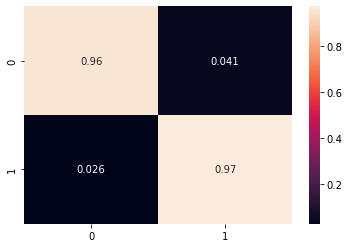

In [75]:
binary_eval(Ytrain, model=tModel_load, predictor=Xtrain_ss)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1105
           1       0.79      0.84      0.81       326

    accuracy                           0.91      1431
   macro avg       0.87      0.89      0.88      1431
weighted avg       0.92      0.91      0.91      1431

aucpr :  0.7
aucroc :  0.8872


(0.7, 0.8872)

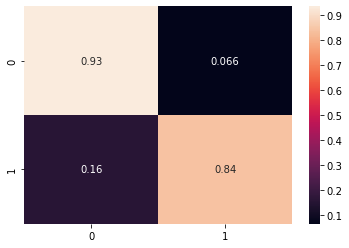

In [76]:
binary_eval(Ytest, model=tModel_load, predictor=Xtest_ss)

## Feature Importance

In [77]:
explainer = shap.TreeExplainer(tModel_load)
# masker = shap.maskers.Independent(data=Xtest_ss)
# explainer = shap.Explainer(
#     tModel_load, masker=masker, feature_names=Xtest_ss.columns, algorithm="linear"
# )
shap_values = explainer.shap_values(Xtrain_ss)

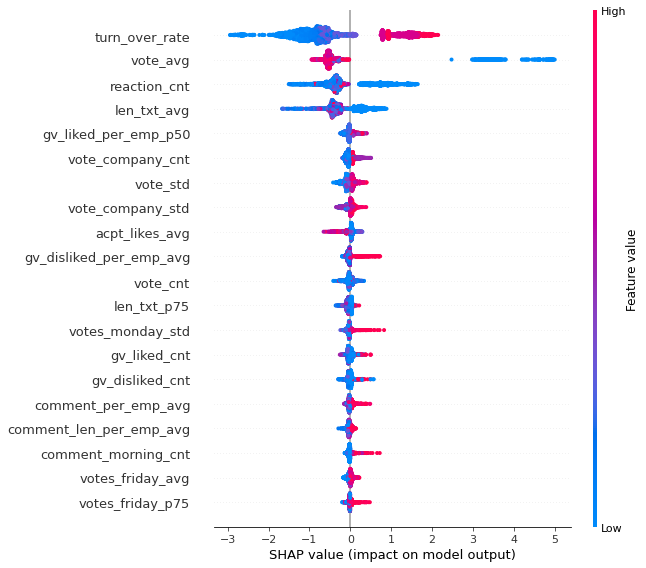

In [78]:
shap.summary_plot(shap_values, features=Xtrain_ss, feature_names=Xtest_ss.columns)

In [79]:
# shap.summary_plot(shap_values, Xtest_ss, plot_type="bar")

In [80]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values, Xtest_ss)

In [81]:
# shap.dependence_plot('vote_avg', shap_values, Xtest_ss)

In [82]:
vals = np.abs(shap_values).mean(0)
feature_names = Xtest_ss.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)

In [83]:
feature_importance.to_csv(PATH_MODEL+'feat_importance_'+VERS+'.csv', index = False)

In [84]:
feature_importance.head()

,col_name,feature_importance_vals
31,turn_over_rate,1.059074
32,vote_avg,0.795475
30,reaction_cnt,0.544933
25,len_txt_avg,0.379717
24,gv_liked_per_emp_p50,0.093870
